In [ ]:
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import BertTokenizer

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Tweets.csv')
print(data.head())


             tweet_id airline_sentiment  airline_sentiment_confidence  \
0  570306133677760513           neutral                        1.0000   
1  570301130888122368          positive                        0.3486   
2  570301083672813571           neutral                        0.6837   
3  570301031407624196          negative                        1.0000   
4  570300817074462722          negative                        1.0000   

  negativereason  negativereason_confidence         airline  \
0            NaN                        NaN  Virgin America   
1            NaN                     0.0000  Virgin America   
2            NaN                        NaN  Virgin America   
3     Bad Flight                     0.7033  Virgin America   
4     Can't Tell                     1.0000  Virgin America   

  airline_sentiment_gold        name negativereason_gold  retweet_count  \
0                    NaN     cairdin                 NaN              0   
1                    NaN    jnar

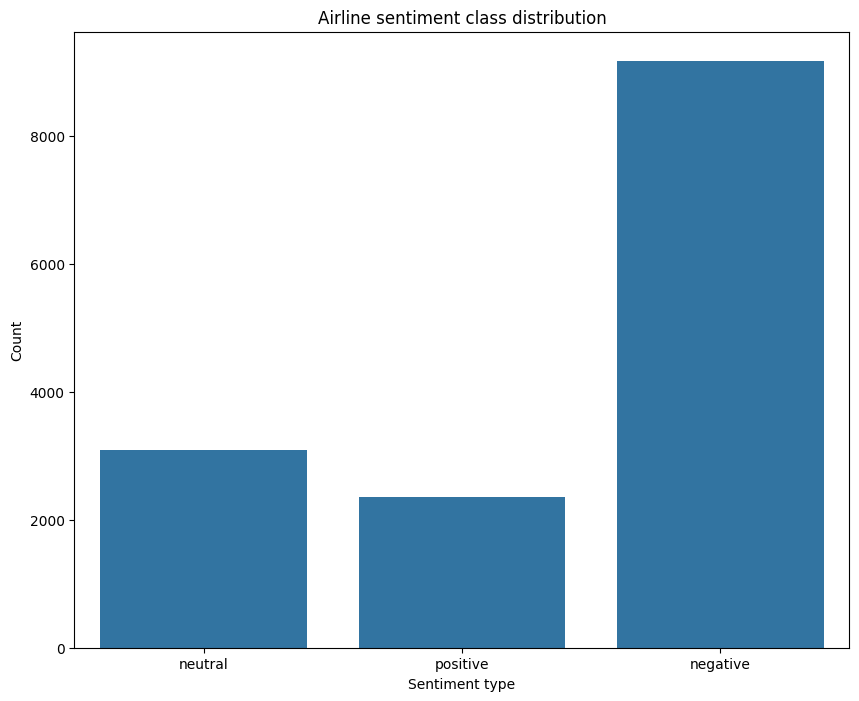

In [ ]:
plt.figure(figsize=(10, 8))
sns.countplot(x='airline_sentiment', data=data)
plt.title('Airline sentiment class distribution')
plt.xlabel('Sentiment type')
plt.ylabel('Count')
plt.show()


In [ ]:
class Dataset(Dataset):
    def __init__(self, texts, labels, token, max_length):
        self.texts = texts
        self.labels = labels
        self.max_length = max_length
        self.token = token

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, index):
        text = self.texts[index]
        label = self.labels[index]
        encode = self.token(text, max_length=self.max_length, padding="max_length", truncation=True, return_tensors="pt")
        input_ids = encode["input_ids"].squeeze()
        return input_ids, label

encode_label = LabelEncoder()
data['airline_sentiment'] = encode_label.fit_transform(data['airline_sentiment'])

X_train, X_temp, y_train, y_temp = train_test_split(data['text'].values, data['airline_sentiment'].values, test_size=0.2, random_state=42, shuffle=True)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, shuffle=True)
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
train_dataset = Dataset(X_train, y_train, tokenizer, 32)
val_dataset = Dataset(X_val, y_val, tokenizer, 32)
test_dataset = Dataset(X_test, y_test, tokenizer, 32)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

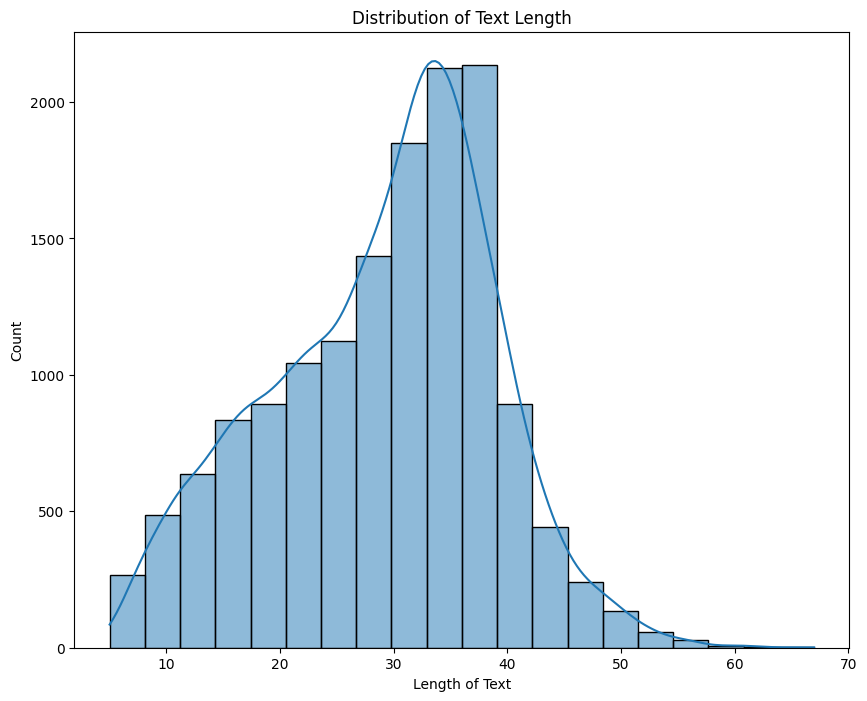

In [ ]:
lengths = [len(tokenizer.encode(text)) for text in data['text'].values]
plt.figure(figsize=(10, 8))
sns.histplot(lengths, bins=20, kde=True)
plt.title('Distribution of Text Length')
plt.xlabel('Length of Text')
plt.ylabel('Count')
plt.show()


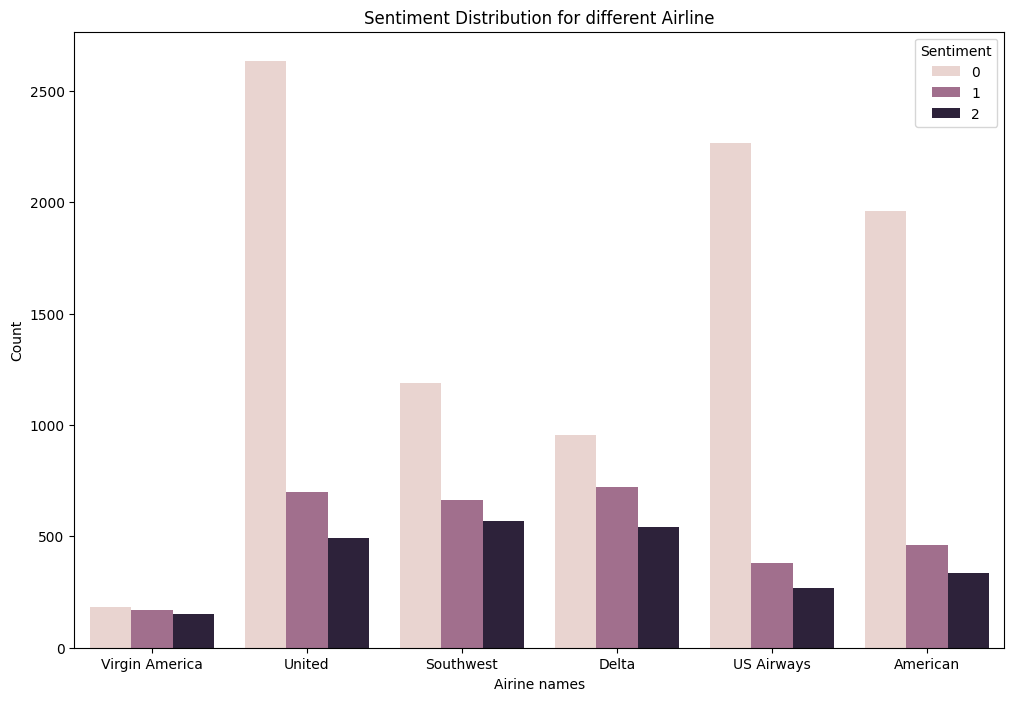

In [ ]:
plt.figure(figsize=(12, 8))
sns.countplot(x='airline', hue='airline_sentiment', data=data)
plt.title('Sentiment Distribution for different Airline')
plt.xlabel('Airine names')
plt.ylabel('Count')
plt.legend(title='Sentiment')
plt.show()


In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, output_dim):
        super(LSTMModel, self).__init__()
        self.embedding = nn.Embedding(tokenizer.vocab_size, embedding_dim)
        self.lstm1 = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.dropout1 = nn.Dropout(0.5)
        self.lstm2 = nn.LSTM(hidden_dim, hidden_dim, batch_first=True)
        self.dropout2 = nn.Dropout(0.5)
        self.lstm3 = nn.LSTM(hidden_dim, hidden_dim, batch_first=True)
        self.dropout3 = nn.Dropout(0.5)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        embedded = self.embedding(x)
        output, _ = self.lstm1(embedded)
        output = self.dropout1(output)
        output, _ = self.lstm2(output)
        output = self.dropout2(output)
        output, _ = self.lstm3(output)
        output = self.dropout3(output)
        output = self.fc(output[:, -1, :])
        return output

In [ ]:
embed_dimension = 128
hidden_dimension = 196
output_dimension = 3
model = LSTMModel(embed_dimension, hidden_dimension, output_dimension)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [ ]:
print("Data Statistics:")
print(data.describe())

Data Statistics:
           tweet_id  airline_sentiment  airline_sentiment_confidence  \
count  1.464000e+04       14640.000000                  14640.000000   
mean   5.692184e+17           0.534495                      0.900169   
std    7.791112e+14           0.756084                      0.162830   
min    5.675883e+17           0.000000                      0.335000   
25%    5.685592e+17           0.000000                      0.692300   
50%    5.694779e+17           0.000000                      1.000000   
75%    5.698905e+17           1.000000                      1.000000   
max    5.703106e+17           2.000000                      1.000000   

       negativereason_confidence  retweet_count  
count               10522.000000   14640.000000  
mean                    0.638298       0.082650  
std                     0.330440       0.745778  
min                     0.000000       0.000000  
25%                     0.360600       0.000000  
50%                     0.670600  

In [ ]:
class_distribution = data['airline_sentiment'].value_counts()
print("\nClass Distribution:")
print(class_distribution)


Class Distribution:
airline_sentiment
0    9178
1    3099
2    2363
Name: count, dtype: int64


In [ ]:
print("\nShapes of Datasets:")
print("Training Dataset Shape:", X_train.shape, y_train.shape)
print("Validation Dataset Shape:", X_val.shape, y_val.shape)
print("Testing Dataset Shape:", X_test.shape, y_test.shape)


Shapes of Datasets:
Training Dataset Shape: (11712,) (11712,)
Validation Dataset Shape: (1464,) (1464,)
Testing Dataset Shape: (1464,) (1464,)


In [ ]:
train_losses = []
val_losses = []
train_accs = []
val_accs = []
num_epochs = 10
start_time = time.time()
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

    train_loss = running_loss / total_train
    train_accuracy = correct_train / total_train
    train_losses.append(train_loss)
    train_accs.append(train_accuracy)
    print(f'Epoch {epoch + 1}/{num_epochs} - Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}')

    model.eval()
    running_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)
    val_loss = running_loss / total_val
    val_accuracy = correct_val / total_val
    val_losses.append(val_loss)
    val_accs.append(val_accuracy)
    print(f'Epoch {epoch + 1}/{num_epochs} - Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}')

end_time = time.time()
total_time = end_time - start_time
print('time taken to train', total_time)

Epoch 1/10 - Train Loss: 0.7886, Train Acc: 0.6580
Epoch 1/10 - Val Loss: 0.6979, Val Acc: 0.7036
Epoch 2/10 - Train Loss: 0.6413, Train Acc: 0.7380
Epoch 2/10 - Val Loss: 0.6390, Val Acc: 0.7473
Epoch 3/10 - Train Loss: 0.5404, Train Acc: 0.7914
Epoch 3/10 - Val Loss: 0.6263, Val Acc: 0.7575
Epoch 4/10 - Train Loss: 0.4543, Train Acc: 0.8293
Epoch 4/10 - Val Loss: 0.6010, Val Acc: 0.7637
Epoch 5/10 - Train Loss: 0.3809, Train Acc: 0.8608
Epoch 5/10 - Val Loss: 0.6175, Val Acc: 0.7725
Epoch 6/10 - Train Loss: 0.3104, Train Acc: 0.8905
Epoch 6/10 - Val Loss: 0.7157, Val Acc: 0.7541
Epoch 7/10 - Train Loss: 0.2424, Train Acc: 0.9215
Epoch 7/10 - Val Loss: 0.7787, Val Acc: 0.7589
Epoch 8/10 - Train Loss: 0.2090, Train Acc: 0.9322
Epoch 8/10 - Val Loss: 0.7610, Val Acc: 0.7650
Epoch 9/10 - Train Loss: 0.1575, Train Acc: 0.9526
Epoch 9/10 - Val Loss: 0.9122, Val Acc: 0.7596
Epoch 10/10 - Train Loss: 0.1376, Train Acc: 0.9602
Epoch 10/10 - Val Loss: 0.9419, Val Acc: 0.7439
time taken to trai

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
model.eval()
test_losses=[]
running_loss = 0.0
correct_test = 0
total_test = 0
start_time=time.time()
labels_true = []
labels_predicted = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        labels_true.extend(labels.cpu().numpy())
        labels_predicted.extend(predicted.cpu().numpy())
        correct_test += (predicted == labels).sum().item()
        total_test += labels.size(0)

test_loss = running_loss / total_test
test_accuracy = correct_test / total_test
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')
end_time=time.time()
testing_time=end_time-start_time
labels_true = np.array(labels_true)
labels_predicted = np.array(labels_predicted)
precision = precision_score(labels_true, labels_predicted, average=None)
recall = recall_score(labels_true, labels_predicted, average=None)
f1 = f1_score(labels_true, labels_predicted, average=None)
print('time taken to test', testing_time)
for i, f1_score in enumerate(f1):
    print(f'F1 Score {i}: {f1_score:.4f}')
for i, recall in enumerate(recall):
    print(f'recall Score {i}: {recall:.4f}')
for i, precision in enumerate(precision):
    print(f'precision Score {i}: {precision:.4f}')


Test Loss: 0.8446, Test Accuracy: 0.7814
time taken to test 3.088735580444336
F1 Score 0: 0.8631
F1 Score 1: 0.5983
F1 Score 2: 0.6834
recall Score 0: 0.8478
recall Score 1: 0.6177
recall Score 2: 0.7075
precision Score 0: 0.8789
precision Score 1: 0.5801
precision Score 2: 0.6608


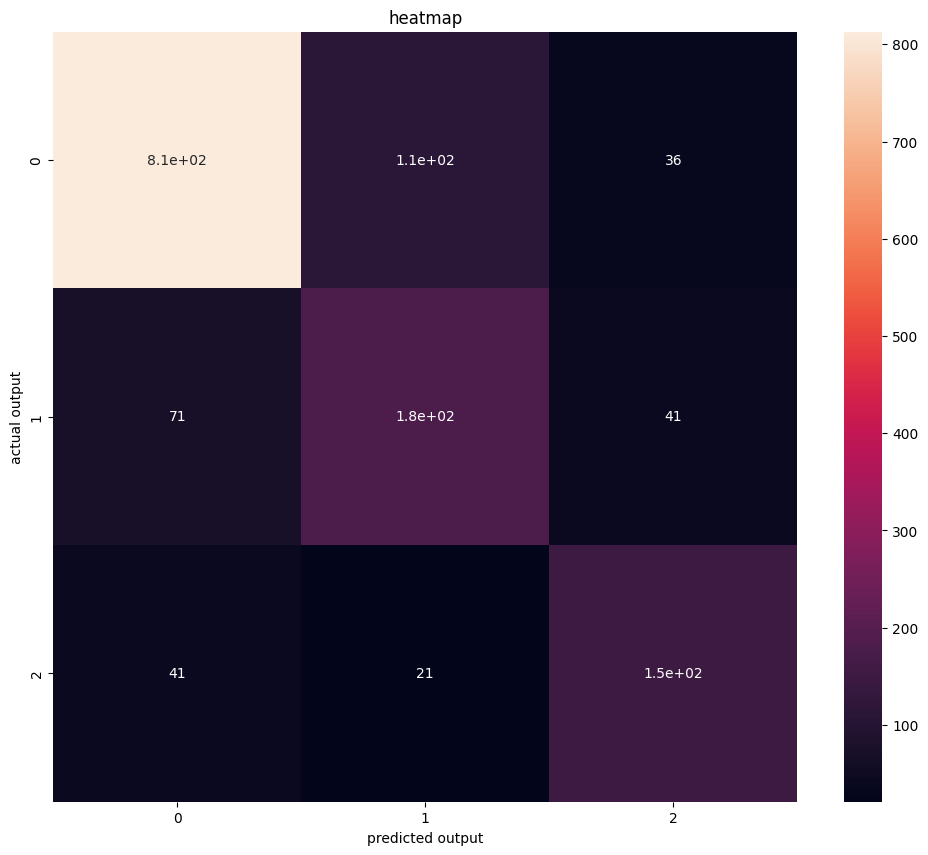

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
plt.figure(figsize=(12,10))
confusion_matrix = confusion_matrix(labels_true, labels_predicted)
sns.heatmap(confusion_matrix, annot=True)
plt.xlabel('predicted output')
plt.ylabel('actual output')
plt.title('heatmap')
plt.show()

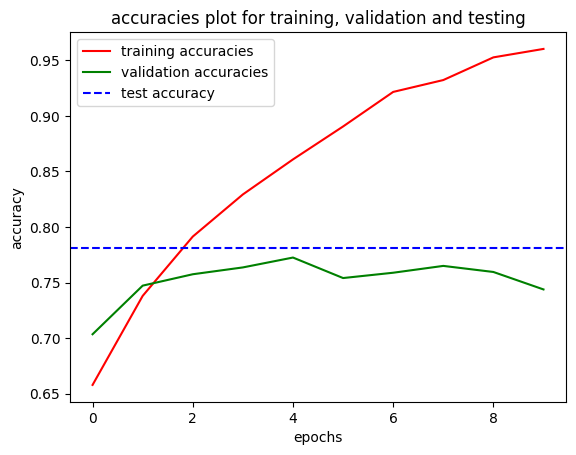

In [ ]:
#accuracy plot for training, validation, testing
plt.plot(train_accs, label = 'training accuracies', color='r')
plt.plot(val_accs, label = 'validation accuracies', color='g')
plt.axhline(test_accuracy, label = 'test accuracy', linestyle='--', color='b')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('accuracies plot for training, validation and testing')
plt.legend()
plt.show()

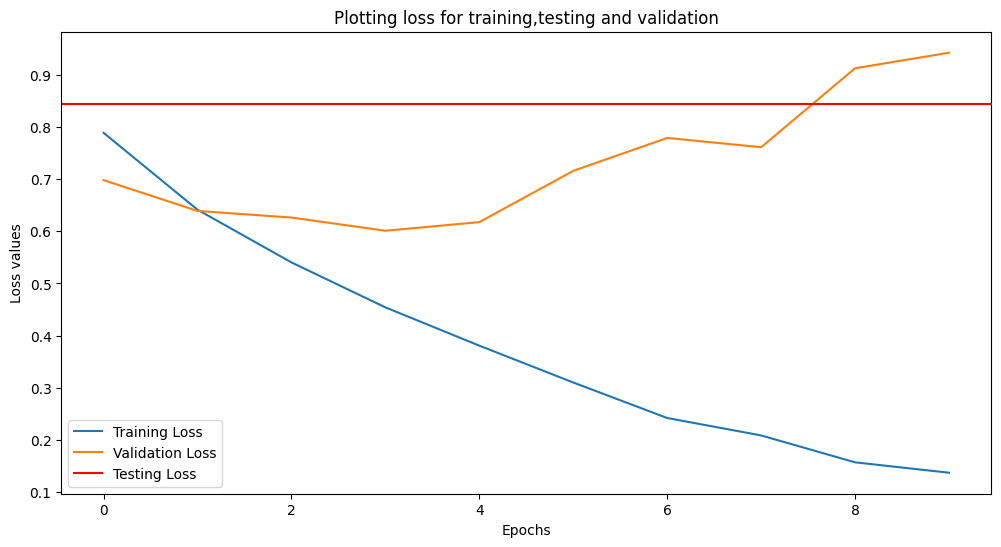

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.axhline(test_loss, label='Testing Loss', color='red')

plt.title('Plotting loss for training,testing and validation')
plt.xlabel('Epochs')
plt.ylabel('Loss values')
plt.legend()
plt.show()


In [ ]:
path = '/content/drive/MyDrive/vmaddila_sentimentAnalysis_LSTM_base.h5'
torch.save(model.state_dict(),path)

In [ ]:
 #GRU- Gated Recurret unit
import torch.nn as nn

class GRUModel(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, output_dim):
        super(GRUModel, self).__init__()
        self.embedding = nn.Embedding(tokenizer.vocab_size, embedding_dim)
        self.gru1 = nn.GRU(embedding_dim, hidden_dim, batch_first=True)
        self.dropout1 = nn.Dropout(0.5)
        self.gru2 = nn.GRU(hidden_dim, hidden_dim, batch_first=True)
        self.dropout2 = nn.Dropout(0.5)
        self.gru3 = nn.GRU(hidden_dim, hidden_dim, batch_first=True)
        self.dropout3 = nn.Dropout(0.5)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        embedded = self.embedding(x)
        output, _ = self.gru1(embedded)
        output = self.dropout1(output)
        output, _ = self.gru2(output)
        output = self.dropout2(output)
        output, _ = self.gru3(output)
        output = self.dropout3(output)
        output = self.fc(output[:, -1, :])
        return output


In [ ]:
embedding_dimension = 128
hidden_dimension = 196
output_dimension = 3
model = GRUModel(embedding_dimension, hidden_dimension, output_dimension)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [ ]:
train_losses = []
val_losses = []
train_accs = []
val_accs = []
num_epochs = 10
start_time = time.time()
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

    train_loss = running_loss / total_train
    train_accuracy = correct_train / total_train
    train_losses.append(train_loss)
    train_accs.append(train_accuracy)
    print(f'Epoch {epoch + 1}/{num_epochs} - Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}')

    model.eval()
    running_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)
    val_loss = running_loss / total_val
    val_accuracy = correct_val / total_val
    val_losses.append(val_loss)
    val_accs.append(val_accuracy)
    print(f'Epoch {epoch + 1}/{num_epochs} - Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}')

end_time = time.time()
total_time = end_time - start_time
print('time taken to train', total_time)

Epoch 1/10 - Train Loss: 0.7659, Train Acc: 0.6756
Epoch 1/10 - Val Loss: 0.6244, Val Acc: 0.7507
Epoch 2/10 - Train Loss: 0.5609, Train Acc: 0.7782
Epoch 2/10 - Val Loss: 0.5609, Val Acc: 0.7760
Epoch 3/10 - Train Loss: 0.4668, Train Acc: 0.8234
Epoch 3/10 - Val Loss: 0.5548, Val Acc: 0.7664
Epoch 4/10 - Train Loss: 0.3891, Train Acc: 0.8567
Epoch 4/10 - Val Loss: 0.5758, Val Acc: 0.7889
Epoch 5/10 - Train Loss: 0.3118, Train Acc: 0.8870
Epoch 5/10 - Val Loss: 0.6218, Val Acc: 0.7835
Epoch 6/10 - Train Loss: 0.2329, Train Acc: 0.9175
Epoch 6/10 - Val Loss: 0.7170, Val Acc: 0.7766
Epoch 7/10 - Train Loss: 0.1707, Train Acc: 0.9452
Epoch 7/10 - Val Loss: 0.7756, Val Acc: 0.7637
Epoch 8/10 - Train Loss: 0.1260, Train Acc: 0.9588
Epoch 8/10 - Val Loss: 0.9218, Val Acc: 0.7486
Epoch 9/10 - Train Loss: 0.0892, Train Acc: 0.9734
Epoch 9/10 - Val Loss: 1.0024, Val Acc: 0.7732
Epoch 10/10 - Train Loss: 0.0738, Train Acc: 0.9775
Epoch 10/10 - Val Loss: 1.0258, Val Acc: 0.7746
time taken to trai

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
model.eval()
test_losses=[]
running_loss = 0.0
correct_test = 0
total_test = 0
start_time=time.time()
labels_true = []
labels_predicted = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        labels_true.extend(labels.cpu().numpy())
        labels_predicted.extend(predicted.cpu().numpy())
        correct_test += (predicted == labels).sum().item()
        total_test += labels.size(0)

test_loss = running_loss / total_test
test_accuracy = correct_test / total_test
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')
end_time=time.time()
testing_time=end_time-start_time
labels_true = np.array(labels_true)
labels_predicted = np.array(labels_predicted)
precision = precision_score(labels_true, labels_predicted, average=None)
recall = recall_score(labels_true, labels_predicted, average=None)
f1 = f1_score(labels_true, labels_predicted, average=None)
print('time taken to test', testing_time)
for i, f1_score in enumerate(f1):
    print(f'F1 Score {i}: {f1_score:.4f}')
for i, recall in enumerate(recall):
    print(f'recall Score {i}: {recall:.4f}')
for i, precision in enumerate(precision):
    print(f'precision Score {i}: {precision:.4f}')


Test Loss: 0.9038, Test Accuracy: 0.8074
time taken to test 2.4695281982421875
F1 Score 0: 0.8847
F1 Score 1: 0.6011
F1 Score 2: 0.7056
recall Score 0: 0.9124
recall Score 1: 0.5529
recall Score 2: 0.6840
precision Score 0: 0.8587
precision Score 1: 0.6585
precision Score 2: 0.7286


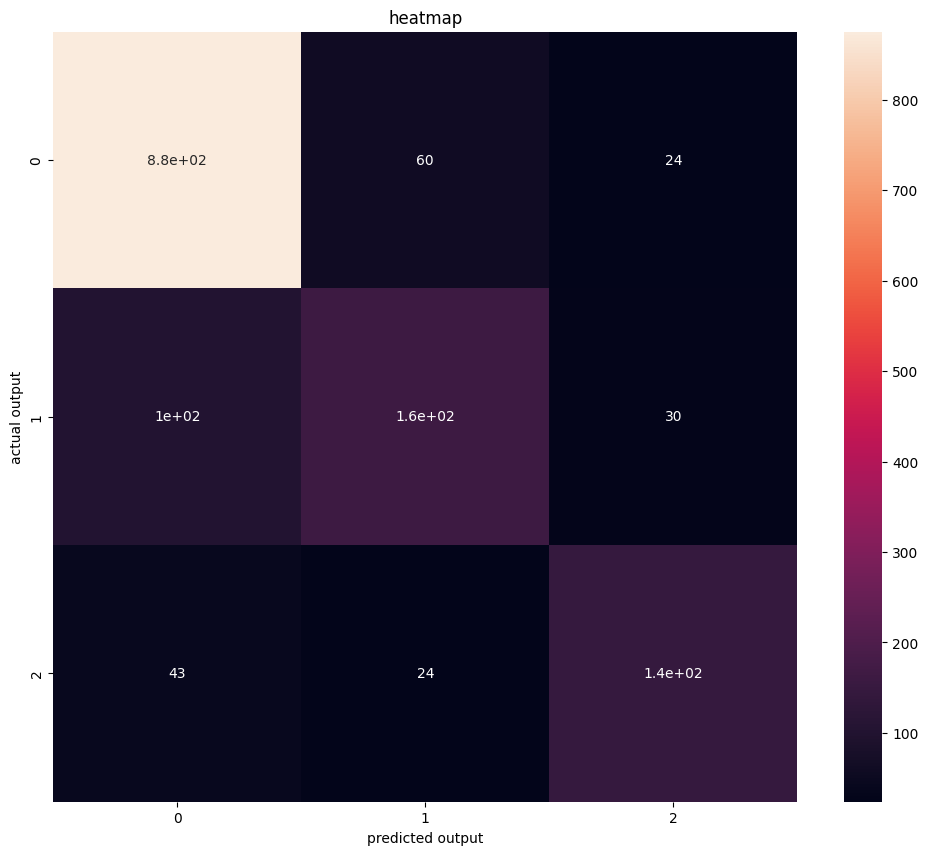

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
plt.figure(figsize=(12,10))
confusion_matrix = confusion_matrix(labels_true, labels_predicted)
sns.heatmap(confusion_matrix, annot=True)
plt.xlabel('predicted output')
plt.ylabel('actual output')
plt.title('heatmap')
plt.show()

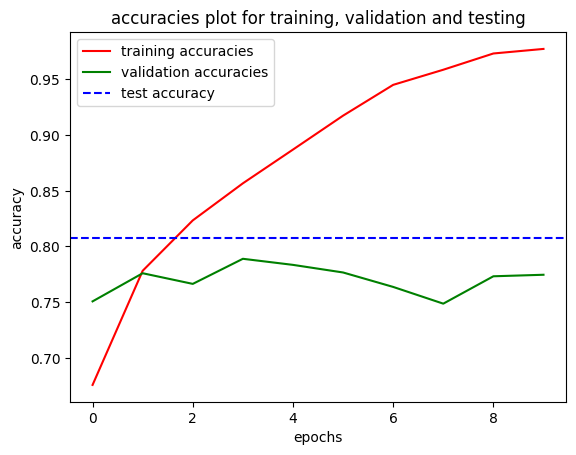

In [ ]:
#accuracy plot for training, validation, testing
plt.plot(train_accs, label = 'training accuracies', color='r')
plt.plot(val_accs, label = 'validation accuracies', color='g')
plt.axhline(test_accuracy, label = 'test accuracy', linestyle='--', color='b')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('accuracies plot for training, validation and testing')
plt.legend()
plt.show()

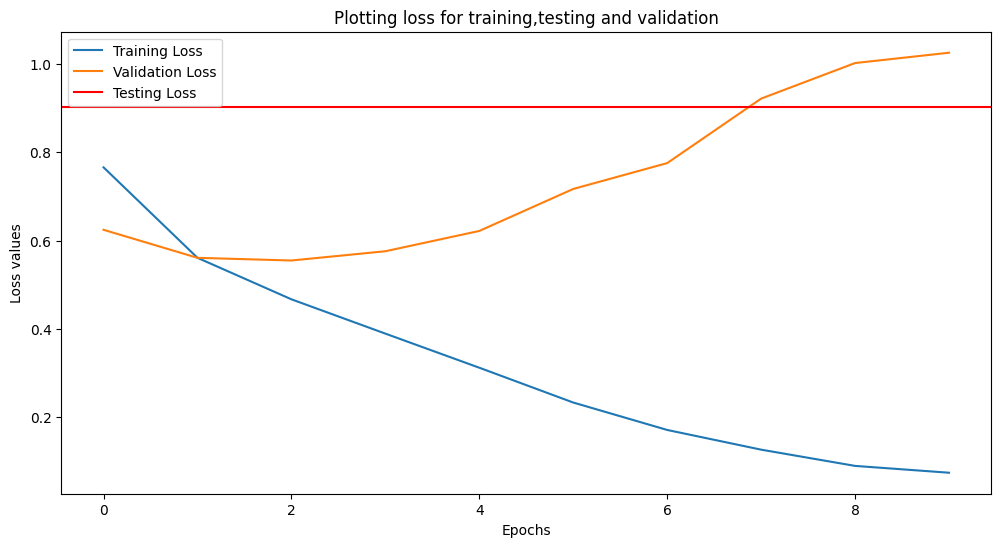

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.axhline(test_loss, label='Testing Loss', color='red')

plt.title('Plotting loss for training,testing and validation')
plt.xlabel('Epochs')
plt.ylabel('Loss values')
plt.legend()
plt.show()


In [ ]:
path = '/content/drive/MyDrive/vmaddila_sentimentAnalysis_GRU.h5'
torch.save(model.state_dict(),path)

In [ ]:
import requests

# Define the URL of the Flask app
url = 'http://localhost:5000/recognize_gesture'

# Read the image file
image_file = open('/content/drive/MyDrive/Capture.PNG', 'rb')

# Create the request payload
files = {'image': image_file}

# Send the POST request
response = requests.post(url, files=files)

# Print the response
print(response.json())


ConnectionError: HTTPConnectionPool(host='localhost', port=5000): Max retries exceeded with url: /recognize_gesture (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x784765f4f490>: Failed to establish a new connection: [Errno 111] Connection refused'))

In [ ]:
from flask import Flask, request, jsonify
import torch
import torch.nn as nn
from transformers import BertTokenizer
import numpy as np

In [ ]:


app = Flask(__name__)

# Define the LSTM model class
class LSTMModel(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, output_dim):
        super(LSTMModel, self).__init__()
        self.embedding = nn.Embedding(tokenizer.vocab_size, embedding_dim)
        self.lstm1 = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.dropout1 = nn.Dropout(0.5)
        self.lstm2 = nn.LSTM(hidden_dim, hidden_dim, batch_first=True)
        self.dropout2 = nn.Dropout(0.5)
        self.lstm3 = nn.LSTM(hidden_dim, hidden_dim, batch_first=True)
        self.dropout3 = nn.Dropout(0.5)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        embedded = self.embedding(x)
        output, _ = self.lstm1(embedded)
        output = self.dropout1(output)
        output, _ = self.lstm2(output)
        output = self.dropout2(output)
        output, _ = self.lstm3(output)
        output = self.dropout3(output)
        output = self.fc(output[:, -1, :])
        return output

# Load the tokenizer and model
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = LSTMModel(embedding_dim=128, hidden_dim=196, output_dim=3)
model.load_state_dict(torch.load('/content/drive/MyDrive/vmaddila_sentimentAnalysis_LSTM_base.h5'))

model.eval()

# Set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

@app.route('/predict', methods=['POST'])
def predict():
    data = request.json
    text = data.get('text', '')

    if not text:
        return jsonify({'error': 'Text is required'}), 400

    # Preprocess the input text
    tokens = tokenizer(text, max_length=32, padding="max_length", truncation=True, return_tensors="pt")
    input_ids = tokens['input_ids'].to(device)

    # Get prediction from the model
    with torch.no_grad():
        output = model(input_ids)
        _, predicted = torch.max(output, 1)
        sentiment = int(predicted.cpu().numpy()[0])

    # Return the prediction as JSON
    return jsonify({'sentiment': sentiment})

if __name__ == '__main__':
    app.run(debug=True)


 * Serving Flask app '__main__'
 * Debug mode: on


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug: * Restarting with stat


In [ ]:
import requests

url = 'http://127.0.0.1:5000/predict'  # Your Flask app's URL
data = {
    'text': 'I had a great experience with the airline!'
}

response = requests.post(url, json=data)

if response.status_code == 200:
    print("Response:", response.json())
else:
    print("Failed to get a response. Status code:", response.status_code)
